## TASK#1
Итак, что нужно сделать: у нас есть данные А/А-теста с '2023-07-23' по '2023-07-29'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [57]:
import pandas as pd
import seaborn as sns
import pandahouse
import statsmodels as stats
import random
from scipy.stats import ttest_ind

In [16]:
#читаем нашу бд

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230820.feed_actions 
WHERE toDate(time) between '2023-07-23' and '2023-07-29'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#дф который мы выгрузили
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [18]:
#проверяем что количество пользователей примерно одинаковое в группах 2 и 3 
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


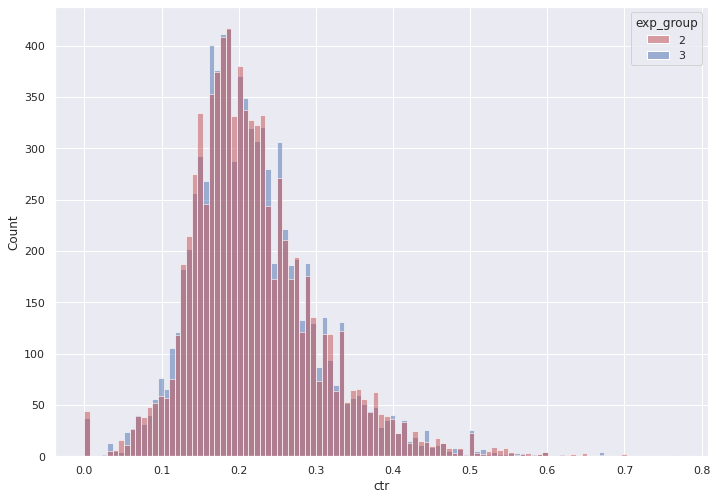

In [83]:
# Вот так наши группы выглядят на гистограмме

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Нулевая гипотеза, которую мы будем проверять:
    До начала нашего эксперимента CTR в двух группах одинаковый, т.е. 
<b> CTR группы 2 = CTR группы 3 </b>

План действий следующий:
1. Сделать 10к неповторяющихся выборок: 500 из группы 2 и 500 из группы3
2. Посчитать 10к раз pvalue при помощи ttest


In [65]:
# создаем цикл на расчет 10к pvalues
sample_size = 500  
pvalues_list = []
for i in range(10000):
    #формируем выборки для группы 2 и 3, по 500 юзеров в каждой
    i_group2 = random.sample(df[df.exp_group == 2].ctr.tolist(), sample_size)
    i_group3 = random.sample(df[df.exp_group == 3].ctr.tolist(), sample_size)
    
    # для каждой пары выборок считаем pvalue и сохраняем его в список    
    i_p = ttest_ind(i_group2, i_group3).pvalue
    pvalues_list.append(i_p)


In [66]:
len(pvalues_list)

10000

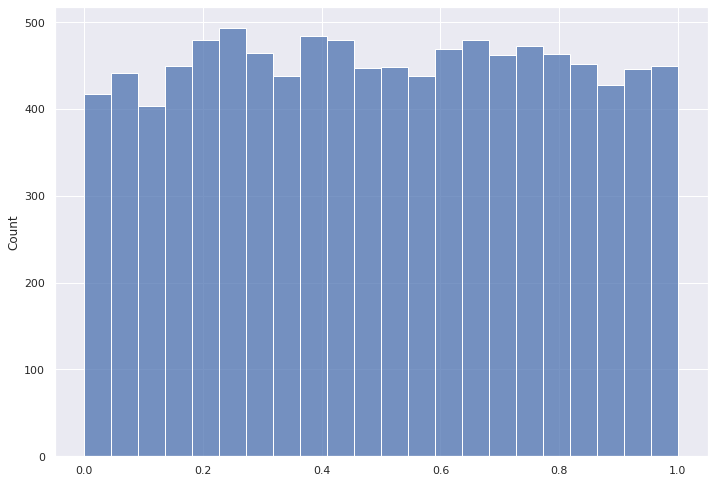

In [67]:
pvalues_distribution = sns.histplot(data = pvalues_list)

In [82]:
# считаем % P-values из наших 10к тестов, у которых значение менее 5%:
len([i for i in pvalues_list if i <= 0.05])/len(pvalues_list)*100

4.62

### Вывод 
Из гистограммы выше видно, что p-values распределены равномерно. Это значит, что вероятность получить любое значение pvalue от 0 до 1 равновероятно по нашим 10 000 t-tests. Вероятность получить p-value меньше 5% - около 5% . А это значит, что из 10к тестов 5% было бы отвергнуто. Из этого можно сделать вывод, что мы <b>не можем опровергнуть нулевую гипотезу</b>, а следовательно наше деление на группы для последующего проведения AB теста - корректное